In [1]:
import mlflow
from camelyon.log_ops import TRACKING_URI

mlflow.set_tracking_uri(TRACKING_URI)

/tmp/ipykernel_2741140/2186416795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_view['params.learning'] = data_view['params.learning'].map(learning_strategy_map)
/tmp/ipykernel_2741140/2186416795.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_view["params.morphology_value"] = data_view["params.morphology_value"].astype(int)


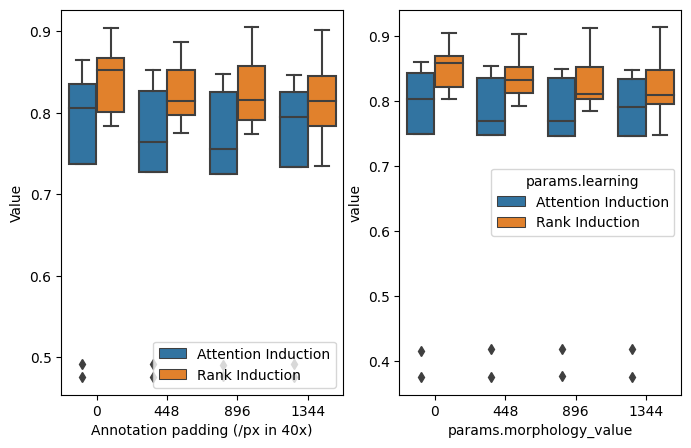

In [6]:
import pandas as pd
import seaborn as sns 
from matplotlib import pyplot as plt

rows = list()

for random_state in range(2018, 2027):
    for morphology_value in [448, 896, 1344]:
        query_rows = mlflow.search_runs(
            experiment_names=["attention_induction"], 
            filter_string=(
            f"params.learning = 'attention_induction' "
            "AND params.sampling_ratio = '1.0' "
            "AND params._lambda = '1.0' "
            "AND params.threshold = 'None' "
            f"AND params.random_state = '{random_state}'"
            f"AND params.morphology_value = '{morphology_value}'"
            )
        )

        if not query_rows.empty and "metrics.test_auroc" in query_rows.columns:
            rows.append(query_rows)
    
        query_rows = mlflow.search_runs(
            experiment_names=["attention_induction"], 
            filter_string=(
            f"params.learning = 'ltr' "
            "AND params.sampling_ratio = '1.0' "
            "AND params._lambda = '1.0' "
            f"AND params.random_state = '{random_state}'"
            f"AND params.morphology_value = '{morphology_value}'"
            )
        )

        if not query_rows.empty and "metrics.test_auroc" in query_rows.columns:
            rows.append(query_rows)

# References
for random_state in range(2018, 2027):
    query_rows = mlflow.search_runs(
        experiment_names=["attention_induction"], 
        filter_string=(
            f"params.learning = 'ltr' "
            "AND params.sampling_ratio = '1.0' "
            "AND params._lambda = '1.0' "
            f"AND params.random_state = '{random_state}' "
            f"AND params.margin = '1.0' " 
        ) # morphology_value not found d/t already recorded in mlflow
    )
    query_rows = query_rows.loc[query_rows["params.morphology_value"].isna()]
    query_rows["params.morphology_value"] = 0
    rows.append(query_rows)
    
for random_state in range(2018, 2027):
    query_rows = mlflow.search_runs(
        experiment_names=["attention_induction"], 
        filter_string=(
            f"params.learning = 'attention_induction' "
            "AND params.sampling_ratio = '1.0' "
            "AND params._lambda = '1.0' "
            f"AND params.random_state = '{random_state}'"
            "AND params.threshold = 'None' "       
        )
    )
    query_rows = query_rows.loc[query_rows["params.morphology_value"].isna()]
    query_rows["params.morphology_value"] = 0
    rows.append(query_rows)

data = pd.concat(rows)
data_view = data[["metrics.test_auroc", "metrics.test_prauc", "metrics.test_accuracy", "params.morphology_value", "params.learning"]]

# Rename
learning_strategy_map = {
    "base": "Base(AB-MIL)", 
    "attention_induction": "Attention Induction", 
    "ltr": "Rank Induction"
}
data_view['params.learning'] = data_view['params.learning'].map(learning_strategy_map)
data_view["params.morphology_value"] = data_view["params.morphology_value"].astype(int)

df_melted = data_view.melt(id_vars=["params.learning", "params.morphology_value"], var_name="metric", value_name="value")
df_melted["metric"] = df_melted["metric"].str.replace("metrics.", "", regex=False)
df_melted["metric"] = df_melted["metric"].replace({
    "test_auroc": "AUROC", 
    "test_prauc": "AUPRC", 
    "test_accuracy": "Accuracy"
})

fig, axes = plt.subplots(1, 2, figsize=(8, 5))


order = list(range(0, 1345, 448))
sns.boxplot(data=df_melted.loc[df_melted["metric"] == "AUROC"], x="params.morphology_value", y="value", hue="params.learning", ax=axes[0])
sns.boxplot(data=df_melted.loc[df_melted["metric"] == "AUPRC"], x="params.morphology_value", y="value", hue="params.learning", ax=axes[1])

axes[0].set_xlabel("Annotation padding (/px in 40x)")
axes[0].set_ylabel("Value")
axes[0].legend(loc='lower right') 

/home/heon/anaconda3/envs/camelyon/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


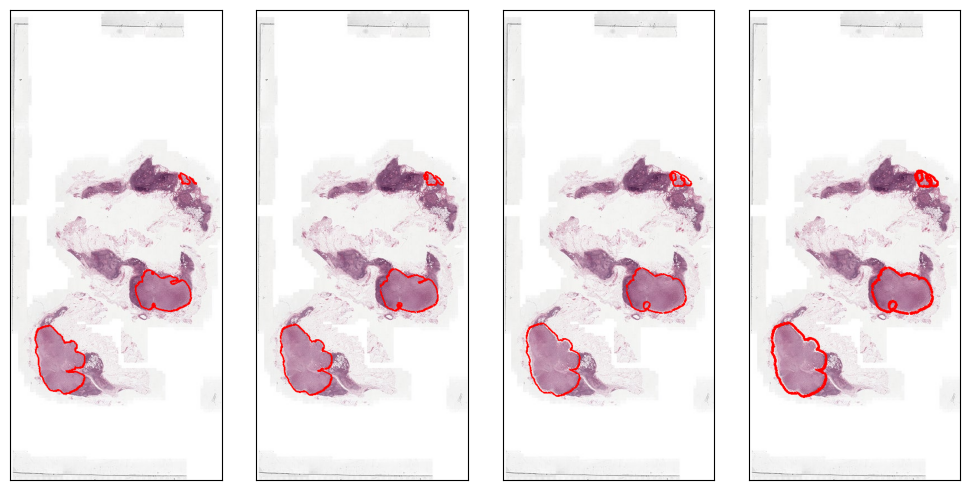

In [ ]:
# Visualization
import numpy as np
from openslide import OpenSlide
from openslide.deepzoom import DeepZoomGenerator

from camelyon.data_models import Polygons

DOWNSAMPLE_RATE = 256

fig, axes = plt.subplots(1, 4, figsize=(10, 5))

file_path = "/vast/AI_team/dataset/CAMELYON16/images/tumor_009.tif"
osr = OpenSlide(file_path)
w, h = osr.dimensions

ploygons = Polygons.from_xml(file_path.replace("images", "annotations").replace(".tif", ".xml"))


reference = np.array(osr.get_thumbnail((w//DOWNSAMPLE_RATE, h//DOWNSAMPLE_RATE)))
for ploygon in ploygons.data:
    xs, ys = ploygon.exterior.xy
    for x, y in zip(xs, ys):
        reference[int(y) // DOWNSAMPLE_RATE, int(x) // DOWNSAMPLE_RATE] = [255, 0, 0]
        reference[int(y) // DOWNSAMPLE_RATE + 1, int(x) // DOWNSAMPLE_RATE + 1] = [255, 0, 0]
        reference[int(y) // DOWNSAMPLE_RATE - 1, int(x) // DOWNSAMPLE_RATE - 1] = [255, 0, 0]
        reference[int(y) // DOWNSAMPLE_RATE, int(x) // DOWNSAMPLE_RATE + 1] = [255, 0, 0]
        reference[int(y) // DOWNSAMPLE_RATE + 1, int(x) // DOWNSAMPLE_RATE] = [255, 0, 0]  
axes[0].imshow(reference)

padding448 = np.array(osr.get_thumbnail((w//DOWNSAMPLE_RATE, h//DOWNSAMPLE_RATE)))
for ploygon in ploygons.data:
    padded_ploygon = ploygon.buffer(448)
    xs, ys = padded_ploygon.exterior.xy
    for x, y in zip(xs, ys):
        padding448[int(y) // DOWNSAMPLE_RATE, int(x) // DOWNSAMPLE_RATE] = [255, 0, 0]
        padding448[int(y) // DOWNSAMPLE_RATE + 1, int(x) // DOWNSAMPLE_RATE + 1] = [255, 0, 0]
        padding448[int(y) // DOWNSAMPLE_RATE - 1, int(x) // DOWNSAMPLE_RATE - 1] = [255, 0, 0]
        padding448[int(y) // DOWNSAMPLE_RATE, int(x) // DOWNSAMPLE_RATE + 1] = [255, 0, 0]
        padding448[int(y) // DOWNSAMPLE_RATE + 1, int(x) // DOWNSAMPLE_RATE] = [255, 0, 0]
axes[1].imshow(padding448)

padding896 = np.array(osr.get_thumbnail((w//DOWNSAMPLE_RATE, h//DOWNSAMPLE_RATE)))
for ploygon in ploygons.data:
    padded_ploygon = ploygon.buffer(896)
    xs, ys = padded_ploygon.exterior.xy
    for x, y in zip(xs, ys):
        padding896[int(y) // DOWNSAMPLE_RATE, int(x) // DOWNSAMPLE_RATE] = [255, 0, 0]
        padding896[int(y) // DOWNSAMPLE_RATE + 1, int(x) // DOWNSAMPLE_RATE + 1] = [255, 0, 0]
        padding896[int(y) // DOWNSAMPLE_RATE - 1, int(x) // DOWNSAMPLE_RATE - 1] = [255, 0, 0]
        padding896[int(y) // DOWNSAMPLE_RATE, int(x) // DOWNSAMPLE_RATE + 1] = [255, 0, 0]
        padding896[int(y) // DOWNSAMPLE_RATE + 1, int(x) // DOWNSAMPLE_RATE] = [255, 0, 0]
axes[2].imshow(padding896)


padding1344 = np.array(osr.get_thumbnail((w//DOWNSAMPLE_RATE, h//DOWNSAMPLE_RATE)))
for ploygon in ploygons.data:
    padded_ploygon = ploygon.buffer(1344)
    xs, ys = padded_ploygon.exterior.xy
    for x, y in zip(xs, ys):
        padding896[int(y) // DOWNSAMPLE_RATE, int(x) // DOWNSAMPLE_RATE] = [255, 0, 0]
        padding896[int(y) // DOWNSAMPLE_RATE + 1, int(x) // DOWNSAMPLE_RATE + 1] = [255, 0, 0]
        padding896[int(y) // DOWNSAMPLE_RATE - 1, int(x) // DOWNSAMPLE_RATE - 1] = [255, 0, 0]
        padding896[int(y) // DOWNSAMPLE_RATE, int(x) // DOWNSAMPLE_RATE + 1] = [255, 0, 0]
        padding896[int(y) // DOWNSAMPLE_RATE + 1, int(x) // DOWNSAMPLE_RATE] = [255, 0, 0]
axes[3].imshow(padding896)


# remove axis labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

